<a href="https://colab.research.google.com/github/tracyhua2/DS3001/blob/main/Labs/Lab_3_Decision_Trees_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Name:** Tracy Hua

## **Computing ID:** njn4gb

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

!pip install lime
from lime import lime_tabular
from sklearn.inspection import permutation_importance

# Below is a new package needed for this lab
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# Lab 3: Decision Trees and Random Forests (100 Points)

The goal of this lab is to optimize Decision Tree and Random Forest models using the provided dataset on census level data. Your goal is to build a Random Forest Classifier to be able to predict income levels above or below 50k.

The guidance this week is less prescriptive in terms of steps, so use the skills you have gained over the semester to build and evaluate your models. You will be graded on your model building, interpretation of the results and explanation of model selection. As always, you are welcome to rely on your classmates but submit your own code. Lastly, there are likely several correct approaches involving a variety of different conclusions, just make sure your conclusions are supported by your approach.


The dataset should be familiar as it's the census data, on 48,000+ individuals with a variety of variables and a target variable for above or below 50k in salary.

![](https://www.coopercenter.org/sites/default/files/styles/wide/public/wordpress_import/Figure1CesnsuBlog2-1024x512_0.png?itok=DwYqkfFm)

Look through the data dictionary at its source link: https://archive.ics.uci.edu/ml/datasets/Adult

# **Part 1: Data Preparation and EDA (15 points)**

In a text cell, answer the following exploratory questions and support your observations with any code, if needed.

## **Question 1 (2 points):**
## Read in the features (X) as a Pandas DataFrame. Show the first 5 rows of the features. How many rows do you have?



In [44]:
# Fetch dataset
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

In [45]:
X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [46]:
len(X)

48842

**There is a total of 48842 rows.**

## **Question 2 (2 points):**
## Are there any potential issues in the data or target that need to be corrected? Why are they issues? What specific method would you use to correct them and why?

## Consider using code and reading the data description (https://archive.ics.uci.edu/dataset/2/adult) to explore:

*   Assumptions and ranges of collected data
*   Missing values (impute? drop?)
*   Numerical data types represented as strings
*   Encoding categorical data appropriately
*   Normalization
*   Standardization

## You will not need to consider feature imbalances or sampling in part 1 or 2 of the lab.

In [47]:
print(X.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object


In [48]:
X.isna().sum()

,0
age,0
workclass,963
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,966
relationship,0
race,0
sex,0


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

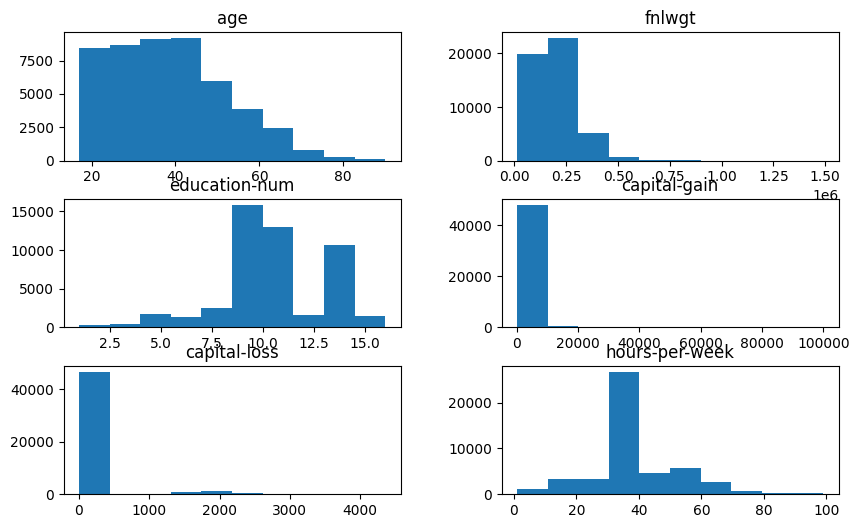

In [49]:
X.hist(figsize=(10,6),bins=10, grid=False)

**Potential Issues:** Potential issues I've identified are:
- Missing values marked as NaN
- Non-numerical columns are stored as 'object' and non-numerical
- Some columns do not have normal distribution (e.g., age, fnlwgt, education-num, capital-gain, capital-loss, and hours-per-week)

## **Question 3 (6 points):**
## Preprocess the data according to the issues and correction methods you've identified. Save the new features and target variable (if necessary) as X_clean and y_clean.

In [50]:
# Impute columns with NAs (workclass, occupation, native-country) with mode value
NA_cols = ['workclass', 'occupation', 'native-country']
for col in NA_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

X.isna().sum()

<ipython-input-50-5c6854b5781d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mode()[0])


,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


## **Question 4 (5 points):**
## Create 2 versions of y_clean to create a new target response of whether income is above or below $50,000 for classification.

1.   **y_clean_binary:** Recode y_clean to be 1 if the target is over or equal to
2.   **y_clean_string:** Recode y_clean to be "Above or Equal" if the target is over or equal to 50,000 and "Below" if under.



# **Part 2: Decision Tree Pruning, Tuning and Evaluation (30 Points)**

## **Question 1 (5 points):**
## Create a function to take in a feature variable (X) and (y). In this function, create a train test split with a random seed of 3001.

## Use a vanilla decision tree model to fit the model on the train set and predict on the test set. Print the precision, recall, and accuracy of the model after prediction.

## Test that your function runs on both y_clean_binary and y_clean_string. For any of the following questions, you may use whichever y_clean variable you'd like.


## **Question 2 (5 points):**
## Adjust your function to include some plotting features. After your prediction code, plot:

1.   A visualization of the resulting decision tree
2.   A confusion matrix of the results

## Your tree might be overwhelming or very large! If it is too large to be interpreted, constrain the max_depth parameter manually to 5 or less.

## **Question 3 (5 points):**
## Create a sorted list of feature importances and comment on the top features.Are there a few that seem to be more important than the others?

## Plot your feature importances in a horizontal or vertical bar chart from most to least important. Label each bar with its feature importance rounded to the nearest integer (ie: 30%).

## **Question 4 (5 points):**
## Write at least 5 sentences interpreting the results of your decision tree, confusion matrix, and feature importance visualizations.

## Is there any aspect of your results that you are uncertain or unsure of?

**My results show...**

## **Question 5 (5 points):**
## Finally, we will create a new function to tune your decision tree to get more accurate and efficient results. Update your function to take in several new parameters with these default values:
* criterion_val ='gini'
* splitter_val ='best'
* max_depth_val = None
* min_samples_split_val = 2
* min_samples_leaf_val =1

## Pass your own variable into the decision tree by specifying what sklearn parameter you are trying to tune. This will simply be the parameter without the "_val" suffix.

## **For example, if your vanilla decision tree variable is called clf, you would adjust it like this:**
`clf = DecisionTreeClassifier(criterion=criterion_val, splitter=splitter_val, ...)`

## **Question 6 (5 points):**

## Call your new function with either clean y variable at least 3 times. Each time, vary the values for all the parameters and examine its effects on your tree, confusion matrix, and metrics.

## You will likely want to look at documentation to see accepted values:  
###https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Why did you pick the values you did? What combination had the best effect on accuracy? Were you surprised by any of the results?

# **Part 3: Random Forest and Ensembling Evaluation (40 Points)**

## For Parts 3 and 4, you may pick *your own dataset* or continue with the census data.

## Like above, you will want to reference the documentation as necessary:
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## **Data**
## Use this space to load and call your data for Parts 3 and 4. You are welcome to use your final project data for these sections.

## **Question 1 (10 points):**

## Write a function to take in a feature variable (X) and a target variable (y). Create a train test split for the variables.

## Finally, instantiate, fit, and predict using **both** a single Decision Tree and a Random Forest classifier. Print the accuracy, precision, and recall for both models.

## Call your function and describe your baseline results.



## **Question 2 (30 points):**
## This question will ask you to tune Random Forest classifiers and preprocess your data in *any number of ways* to achieve the *best possible results you can*.

## Train one vanilla Decision Forest model and one vanilla Random Forest model and store their accuracies in variables so you can use them as baselines.

## Then, using functions or not, spend some time tuning at least 10 (or more) Random Forest models. Store your accuracies in a list or array and print your maximum accuracy.

# **Go crazy - feel free to implement sampling, dropping features, preprocessing, new parameters, whatever might boost your accuracy.**

# **The top 5 best accuracies in the class will get +15 on their individual lab grade!**

# **Part 4: Ensemble Model Interpretation and Reflection (15 Points)**


## **Question 1 (5 points):**
## Create a plot that summarizes the results of your experiments and how they compare to the results of your baseline Decision Tree and Random Forest model.

## You may visualize your results in any type of plot you see fit. Color code your visual in some way so that models that did better than the baseline Random Forest are distinguished from models that did worse.

## **Question 2 (5 points):**
## Write 10 or more sentences on what parameters had the biggest effect or did not seem to effect your results. Did any parameter choices make your results worse than your vanilla model?

**The parameters I chose...**

## **Question 3 (5 points):**
## Write 10 or more sentences reflecting on the tuning process.

## What kind of approach did you take? Was it random combinations or more structured? Did you change your approach after seeing your initial results?

## What kind of strategies in preprocessing and picking parameters (ie: brute forcing parameters, testing various values in a range) do you think would get some of the best scores in the class?

**My approach to tuning...**

### Honor Pledge

On my honor as a student, I have neither given nor received unauthorized aid on this assignment.